## Imports

In [1]:
import json
import os
import pandas as pd
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
import warnings

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
from PIL import Image
from sklearn.cluster import Birch

## Config

In [3]:
# Pandas and code stuff
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

# Plot configuration
font_path = "../assets/fonts/Helotypo.ttf"
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Helotypo'

In [5]:
# Create custom Colormap
original_cmap = cm.get_cmap('cool', 256)
colors = original_cmap(np.linspace(0,1, 256))
neg_colors = colors[:128]
pos_colors = colors[128:]

neg_alpha = np.linspace(1, 0, 128)
pos_alpha = np.linspace(0, 1 , 128)
new_colors = np.vstack([neg_colors, pos_colors])

new_colors[:128, 3] = neg_alpha
new_colors[128:, 3] = pos_alpha

custom_cmap = LinearSegmentedColormap.from_list('tr_cool', new_colors)

## Constants

In [6]:
raw_data_path = '../data/raw/'
data_path = 'nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final/train/input_2023_w18.csv'
supplementary_data_path = "../data/raw/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final/supplementary_data.csv"

complete_data_path = os.path.join(raw_data_path, data_path)
ref_metrics_path = '../data/processed/reference_metrics.json'

icons = {
    "Offense": "../assets/icons/attacking_player.png",
    "Defense": "../assets/icons/defensive_player.png",
    'ball': '../assets/icons/nfl_ball.png',
}

nfl_image = '../assets/figures/NFL-logo.png'

In [7]:
## Functions

In [8]:
# ---------- helpers
def _height_to_inches(h):
    if pd.isna(h): return np.nan
    if isinstance(h, (int, float)): return float(h)
    s = str(h)
    if "-" in s:
        ft, inch = s.split("-", 1)
        try: return 12*int(ft) + int(inch)
        except: pass
    try: return float(s)
    except: return np.nan

def add_team_cohesion(frame_df, radius=12.0):
    angle_const = 0
    """Adds column 'team_cohesion' per frame: proximity * alignment (dir & orientation)."""
    df = frame_df.copy()
    X = df['x'].to_numpy()
    Y = df['y'].to_numpy()
    side = df['player_side_numerical'].to_numpy()
    th = np.deg2rad((df['dir'] + angle_const).to_numpy())
    ori = np.deg2rad((df['o'] + angle_const).to_numpy())
    n = len(df)
    cohesion = np.zeros(n)
    for i in range(n):
        same = np.where((side == side[i]) & (np.arange(n) != i))[0]
        if same.size == 0:
            continue
        dx = X[same] - X[i]; dy = Y[same] - Y[i]
        dist = np.hypot(dx, dy)
        m = dist < radius
        if not np.any(m): continue
        dx = dx[m]; dy = dy[m]; dist = dist[m]
        jidx = same[m]
        alpha = np.arctan2(dy, dx)  # bearing i->j
        look_dir = np.cos(th[i] - alpha) * np.cos(th[jidx] - alpha)
        look_ori = np.cos(ori[i] - alpha) * np.cos(ori[jidx] - alpha)
        look = 0.5*(look_dir + look_ori)
        w = 1.0 / (dist + 1e-6)
        cohesion[i] = (w * np.maximum(0.0, look)).sum() / (w.sum() + 1e-6)
    df['team_cohesion'] = cohesion
    return df

def normalize_two_sided(D, eps=1e-12):
    """
    Piecewise normalization:
      negatives -> [-1, 0], positives -> [0, 1], zeros stay 0.
      D is a 2D numpy array (the aggregated dominance field).
    """
    # split into positive and negative parts
    pos = np.maximum(D, 0.0)
    neg = np.minimum(D, 0.0)

    pmax = float(pos.max()) if pos.size else 0.0
    nmin = float(neg.min()) if neg.size else 0.0  # <= 0

    # scale each side independently
    if pmax > eps:
        pos = pos / pmax
    else:
        pos = np.zeros_like(pos)

    if nmin < -eps:                  # nmin is negative
        neg = neg / (-nmin)          # divide by abs(min) -> [-1, 0]
    else:
        neg = np.zeros_like(neg)

    return pos + neg


# ---------- main kernel
def dominance_function(row,
                       t_h=0.5,
                       r0=3.0,
                       s_ref=10.93,   # yd/s  (~22.36 mph)
                       a_ref=7.0,     # yd/s^2 (tunable)
                       h_ref=74.0,    # inches (~6'2")
                       w_ref=220.0,   # lb
                       betas=(0.8, 0.4, 0.3, 0.6),  # beta_s, beta_a, beta_h, gamma_s
                       alphas=(0.4, 0.3, 0.2, 0.1), # ke, momentum, force, action
                       lambda_cohesion=0.5):
    """
    Returns f(X, Y) -> dominance for this player over the whole grid (vectorized).
    Expects row to have: x,y,s,a,dir,o,player_weight,player_height,player_side_numerical[,team_cohesion]
    """
    beta_s, beta_a, beta_h, gamma_s = betas
    a_ke, a_p, a_f, a_act = alphas

    # Angles
    angle_const = 0
    theta = np.deg2rad(row['dir'] + angle_const)
    c, s = np.sin(theta), np.cos(theta)

    # Forward-looking mean (assume accel collinear with dir)
    x0 = row['x'] + t_h*row['s']*c + 0.5*(t_h**2)*row['a']*c
    y0 = row['y'] + t_h*row['s']*s + 0.5*(t_h**2)*row['a']*s

    # Height -> reach base
    h_in = _height_to_inches(row['player_height'])
    H = 0.0 if np.isnan(h_in) else (h_in - h_ref) / h_ref
    r_reach = r0 * (1.0 + 0.5*H)

    # Anisotropic spreads
    s_long = r_reach * (1.0 + beta_s*(row['s']/s_ref) + beta_a*(abs(row['a'])/a_ref))
    s_lat  = r_reach * (1.0 + beta_h*H) / (1.0 + gamma_s*(row['s']/s_ref))
    s_lat  = max(s_lat, 0.6*r_reach)

    a2, b2 = s_long**2, s_lat**2   # along, across (in rotated frame)

    # Mechanical amplitude (ref-normalized, unit-safe by consistency)
    w = row['player_weight']
    spd = row['s']
    acc = abs(row['a'])
    d = spd * t_h
    KE = 0.5*w*spd**2
    MOM  = w*spd
    FORC = w*acc
    ACT  = w*spd**2*t_h

    KE_ref   = 0.5*w_ref*s_ref**2
    MOM_ref  = w_ref*s_ref
    FORC_ref = w_ref*a_ref
    ACT_ref  = w_ref*s_ref**2*t_h

    M = (a_ke*(KE/KE_ref) +
         a_p *(MOM/MOM_ref) +
         a_f *(FORC/FORC_ref) +
         a_act*(ACT/ACT_ref))
    M = max(M, 1e-6)

    # Orientation-to-motion stability
    S = 0.5*(1.0 + np.cos(np.deg2rad(row['o'] - row['dir'])))

    # Teamwork (optional column; default 0)
    C = float(row['team_cohesion']) if 'team_cohesion' in row.index else 0.0
    A = M * S * (1.0 + lambda_cohesion*C)

    sign = row['player_side_numerical']

    # Return vectorized callable over grid X, Y
    def f(X, Y):
        dx = X - x0
        dy = Y - y0
        # rotate residuals into (along, across) frame — no explicit matrix inverse needed
        u = c*dx + s*dy  # along dir
        v = -s*dx + c*dy  # across dir
        quad = (u*u)/a2 + (v*v)/b2
        G = np.exp(-0.5*quad) / (2*np.pi*np.sqrt(a2*b2))
        return sign * A * G

    return f

In [9]:
# ---------- visualisation helpers
def plot_field(subplots=1, figsize=(12*2, 5.33333*2)):
  '''Function to plot the football field. '''
  stadium_limit_dimension_y =  (0, 53.3333333)
  stadium_limit_dimension_x = (0, 120)
  color__green = "#586d3d"
  color__white = "#DADADA"
  color__brown = "#663831"
  color__yellow = "#cbb67c"
  text_position = 5
  portery_yards = 6.166667
  numbers = {20:'1 0', 30:'2 0', 40:'3 0', 50:'4 0', 60:'5 0', 70:'4 0', 80:'3 0', 90:'2 0', 100:'1 0'}

  fig, ax = plt.subplots(subplots, figsize=figsize)
  ax.set_xlim(stadium_limit_dimension_x)
  ax.set_ylim(stadium_limit_dimension_y)
  ax.vlines(
      [i for i in range(0, max(stadium_limit_dimension_x), 10)],
      min(stadium_limit_dimension_y),
      max(stadium_limit_dimension_y),
      color=color__white,
      alpha=0.5
  )

  ax.vlines(
      [i for i in range(10, max(stadium_limit_dimension_x)-10, 5)],
      min(stadium_limit_dimension_y),
      max(stadium_limit_dimension_y),
      color=color__white,
      alpha=0.3
  )

  vlines2 = [i for i in range(10, max(stadium_limit_dimension_x)-10+1, 1)]
  vlines2_size=1
  ax.vlines(
      vlines2,
      min(stadium_limit_dimension_y),
      min(stadium_limit_dimension_y) + vlines2_size,
      color=color__white,
      alpha=0.3
  )
  ax.vlines(
      vlines2,
      max(stadium_limit_dimension_y),
      max(stadium_limit_dimension_y) - vlines2_size,
      color=color__white,
      alpha=0.5
  )

  vlines3_size = 0.5
  medium_vlines_pos = (min(stadium_limit_dimension_y) + max(stadium_limit_dimension_y))/2 + portery_yards/2
  medium_vlines_neg = (min(stadium_limit_dimension_y) + max(stadium_limit_dimension_y))/2 - portery_yards/2
  ax.vlines(
      vlines2,
      medium_vlines_pos + vlines3_size,
      medium_vlines_pos - vlines3_size,
      color=color__white,
      alpha=0.3
  )
  ax.vlines(
      vlines2,
      medium_vlines_neg + vlines3_size,
      medium_vlines_neg - vlines3_size,
      color=color__white,
      alpha=0.3
  )
  for p, n in numbers.items():
    ax.text(p, min(stadium_limit_dimension_y) + text_position, n, horizontalalignment='center', verticalalignment='center', color=color__white, rotation=0)
    ax.text(p, max(stadium_limit_dimension_y) - text_position, n, horizontalalignment='center', verticalalignment='center', color=color__white, rotation=180)

  triangle_pos = [(i + (i-5))/2 for i in range(20, max(stadium_limit_dimension_x)//2-10+1, 10)]
  ax.scatter(triangle_pos, [min(stadium_limit_dimension_y) + text_position]*len(triangle_pos), marker='<', s=10, color=color__white)
  ax.scatter(triangle_pos, [max(stadium_limit_dimension_y) - text_position]*len(triangle_pos), marker='<', s=10, color=color__white)

  triangle_pos2 = [(i + (i+5))/2 for i in range(70, max(stadium_limit_dimension_x)-10, 10)]
  ax.scatter(triangle_pos2, [min(stadium_limit_dimension_y) + text_position]*len(triangle_pos2), marker='>', s=10, color=color__white)
  ax.scatter(triangle_pos2, [max(stadium_limit_dimension_y) - text_position]*len(triangle_pos2), marker='>', s=10, color=color__white)
  ax.set_facecolor(color__green)
  ax.set_xticks([])
  ax.set_yticks([])
  logosize = 7
  extent = (
      stadium_limit_dimension_x[1]//2-logosize,
      stadium_limit_dimension_x[1]//2+logosize,
      stadium_limit_dimension_y[1]//2-logosize,
      stadium_limit_dimension_y[1]//2+logosize
  )
  ax.imshow(plt.imread(nfl_image), aspect='equal', extent=extent, alpha=0.5)
  return fig, ax

def plot_field(ax=None, figsize=(24, 10.6667), nfl_image=None):
    """
    Plot an NFL field on the given axis (or create one if ax is None).

    Parameters
    ----------
    ax : matplotlib.axes.Axes or iterable[Axes], optional
        Axis (or collection of axes) to draw on. If None, a new figure/axis is created.
    figsize : tuple, optional
        Figure size used only if ax is None.
    nfl_image : str or array-like, optional
        Path to an image or already-loaded array to place at midfield (faint logo).

    Returns
    -------
    If a new axis is created: (fig, ax)
    If ax is provided: ax (same object), for convenience
    """
    # ---- constants ----
    stadium_limit_dimension_y = (0, 53.3333333)
    stadium_limit_dimension_x = (0, 120)
    
    color__green  = "#586d3d"
    color__white  = "#DADADA"
    
    text_position = 5
    portery_yards = 6.166667
    numbers = {20:'1 0', 30:'2 0', 40:'3 0', 50:'4 0', 60:'5 0', 70:'4 0', 80:'3 0', 90:'2 0', 100:'1 0'}

    def _draw(ax_):
        # limits
        ax_.set_xlim(stadium_limit_dimension_x)
        ax_.set_ylim(stadium_limit_dimension_y)

        # 10-yd major lines
        ax_.vlines(
            [i for i in range(0, int(max(stadium_limit_dimension_x))+1, 10)],
            min(stadium_limit_dimension_y),
            max(stadium_limit_dimension_y),
            color=color__white, alpha=0.5
        )

        # 5-yd minor lines (no endzones)
        ax_.vlines(
            [i for i in range(10, int(max(stadium_limit_dimension_x))-10, 5)],
            min(stadium_limit_dimension_y),
            max(stadium_limit_dimension_y),
            color=color__white, alpha=0.3
        )

        # small ticks on sidelines every yard
        vlines2 = [i for i in range(10, int(max(stadium_limit_dimension_x))-10+1, 1)]
        v2 = 1.0
        ax_.vlines(vlines2, min(stadium_limit_dimension_y),
                   min(stadium_limit_dimension_y)+v2, color=color__white, alpha=0.3)
        ax_.vlines(vlines2, max(stadium_limit_dimension_y),
                   max(stadium_limit_dimension_y)-v2, color=color__white, alpha=0.5)

        # hash marks (inside numbers)
        v3 = 0.5
        mid_y = (min(stadium_limit_dimension_y) + max(stadium_limit_dimension_y)) / 2
        hash_pos = mid_y + portery_yards/2
        hash_neg = mid_y - portery_yards/2
        ax_.vlines(vlines2, hash_pos + v3, hash_pos - v3, color=color__white, alpha=0.3)
        ax_.vlines(vlines2, hash_neg + v3, hash_neg - v3, color=color__white, alpha=0.3)

        # yard numbers
        for p, n in numbers.items():
            ax_.text(p, min(stadium_limit_dimension_y) + text_position, n,
                     ha='center', va='center', color=color__white, rotation=0)
            ax_.text(p, max(stadium_limit_dimension_y) - text_position, n,
                     ha='center', va='center', color=color__white, rotation=180)

        # little triangles next to numbers (directional)
        triangle_pos  = [(i + (i-5))/2 for i in range(20, int(max(stadium_limit_dimension_x)//2)-10+1, 10)]
        triangle_pos2 = [(i + (i+5))/2 for i in range(70, int(max(stadium_limit_dimension_x))-10, 10)]
        ax_.scatter(triangle_pos,  [min(stadium_limit_dimension_y) + text_position]*len(triangle_pos),
                    marker='<', s=10, color=color__white)
        ax_.scatter(triangle_pos,  [max(stadium_limit_dimension_y) - text_position]*len(triangle_pos),
                    marker='<', s=10, color=color__white)
        ax_.scatter(triangle_pos2, [min(stadium_limit_dimension_y) + text_position]*len(triangle_pos2),
                    marker='>', s=10, color=color__white)
        ax_.scatter(triangle_pos2, [max(stadium_limit_dimension_y) - text_position]*len(triangle_pos2),
                    marker='>', s=10, color=color__white)

        # aesthetics
        ax_.set_facecolor(color__green)
        ax_.patch.set_alpha(0.8)
        ax_.set_xticks([])
        ax_.set_yticks([])
        ax_.set_aspect('equal')

        # midfield logo (optional)
        if nfl_image is not None:
            if isinstance(nfl_image, str):
                img = plt.imread(nfl_image)
            else:
                img = nfl_image  # assume array
            logosize = 7
            extent = (
                stadium_limit_dimension_x[1]//2 - logosize,
                stadium_limit_dimension_x[1]//2 + logosize,
                stadium_limit_dimension_y[1]//2 - logosize,
                stadium_limit_dimension_y[1]//2 + logosize
            )
            ax_.imshow(img, aspect='equal', extent=extent, alpha=0.5)

        return ax_

    # ---- handle single / multiple axes or create new ----
    if ax is None:
        fig, ax_new = plt.subplots(1, 1, figsize=figsize)
        _draw(ax_new)
        return fig, ax_new

    # ax provided
    try:
        # If it's array-like of axes
        _ = iter(ax)
        for a in ax:
            _draw(a)
        return ax
    except TypeError:
        # Single axis
        return _draw(ax)

def create_gif(image_paths, output_gif_path, fps=5):
  images = [Image.open(image_path) for image_path in image_paths]
  images[0].save(
    output_gif_path,
    save_all=True,
    append_images=images[1:],
    fps=fps,
    loop=0 # 0 means infinite loop
  )

def save_gif(filename, fps=5):
    image_paths = [os.path.join(f'../experiments/figures/{filename}', p) for p in sorted(os.listdir(f'../experiments/figures/{filename}'))]
    #filename_split = filename.split('_')[-1]
    output_gif_path = f"../experiments/outputs/output__{filename}.gif"
    create_gif(image_paths, output_gif_path, fps=fps)

def create_folder(filename, path="../experiments/figures/"):
    complete_path = os.path.join(path, filename)
    if os.path.exists(complete_path):
        return None
    os.mkdir(complete_path)
    return complete_path

def save_figs(information, filename, show=False, save=False, stop_counter=None):
    complete_path = create_folder(filename=filename)
    counter=0
    for idx, row in information.iterrows():
        increasing_information = information.loc[:idx]
        time_component = pd.to_datetime(increasing_information.time, format='ISO8601')
        time_component = (time_component - time_component.min()).dt.total_seconds()

        fig, ax = plot_field(subplots=2, figsize=(15,10))
        
        draw_graph(row.graphs, ax=ax[0])
    
        ax[1].plot(
            increasing_information.time_component, 
            increasing_information.model_pred,
            color='blue', 
            marker='o',
            markerfacecolor='k',
            markersize=3,
            label='Model score',
        )
        increasing_information_events = increasing_information[
            increasing_information.event.notna()
        ]
    
        ax[1].vlines(
            increasing_information_events.time_component, 
            [0 - 0.0] * increasing_information_events.shape[0], 
            [1 - 0.05] * increasing_information_events.shape[0],
            color='k',
            alpha=0.8,
        )
    
        counter_text = 0
        for _, row_event in increasing_information_events.iterrows():
            counter_text +=1
            ax[1].text(
                row_event.time_component, 
                counter_text%2 - (-1)**counter_text*0.05,
                row_event.event, 
                size=5,  
                horizontalalignment='center', 
                verticalalignment='center',
            )
        ax[1].set_ylim(-0.15, 1.1)
    
        plt.suptitle('Play development over time.')
        ax[1].set_title('Overall play behavior')
        ax[1].set_title(f'Model prediction [game:{game_id}, play:{play_id}]')
        ax[1].set_xlabel('Seconds from ball snap')
        ax[1].set_ylabel('Probability of Pass Forward prediction \n(caught) at  the next 0.5 second.')
        ax[1].grid(linestyle='--')
    
        ax[1].legend()
        if show:
            plt.show()
        if save:
            plt.savefig(f'{complete_path}/test_{str(counter).zfill(3)}.png')
        plt.close(fig)
        counter += 1
        if stop_counter:
            if counter==stop_counter:
                break

def scatter_png(ax, df, x='x', y='y', side='player_side',
                icons=None, size=0.02, zorder=3):
    """
    Draw PNG icons at (x,y) positions.
    size: fraction of x-axis span used as icon width (keeps PNG aspect).
    """
    # preload images once
    imgs = {k: mpimg.imread(v) for k, v in icons.items()}

    # set nice limits if none exist
    if not ax.has_data():
        ax.set_xlim(df[x].min()-2, df[x].max()+2)
        ax.set_ylim(df[y].min()-2, df[y].max()+2)

    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    xspan = x1 - x0
    yspan = y1 - y0

    for _, r in df.iterrows():
        img = imgs[r[side]]
        h, w = img.shape[:2]
        w_data = xspan * size
        # keep image aspect, correct for axis scaling
        h_data = w_data * (h / w) * (yspan / xspan)

        ax.imshow(
            img,
            extent=(r[x] - w_data/2, r[x] + w_data/2, r[y] - h_data/2, r[y] + h_data/2),
            origin="upper",
            zorder=zorder,
            interpolation="none"
        )

    return ax

def player_ids(ax, df, x='x', y='y', ids='nfl_id', id_func=None):        
    for _, r in df.iterrows():
        if id_func is None:
            text = r[ids]
        else:
            text = id_func(r[ids])
        ax.text(
            s= text,
            x=r[x] + r['player_side_numerical'],
            y=r[y] + r['player_side_numerical']*2,
            ha='center',
            va='center',
        )
    return ax

def plot_ball_land(ax, df, icons, size=0.02, zorder=3):
    """
    Draw PNG ball icons at the landing (x,y) position.
    size: fraction of x-axis span used as icon width (keeps PNG aspect).
    """
    # preload images once
    imgs = {k: mpimg.imread(v) for k, v in icons.items()}

    # set nice limits if none exist
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    xspan = x1 - x0
    yspan = y1 - y0

    img = imgs['ball']
    h, w = img.shape[:2]
    w_data = xspan * size
    # keep image aspect, correct for axis scaling
    h_data = w_data * (h / w) * (yspan / xspan)
    ball_land_x = df.ball_land_x.unique()[0]
    ball_land_y = df.ball_land_x.unique()[0]

    ax.imshow(
        img,
        extent=(ball_land_x - w_data/4, ball_land_x + w_data/4, ball_land_y - h_data/2, ball_land_y + h_data/2),
            origin="upper",
            zorder=zorder,
            interpolation="none"
        )

    return ax

def plot_player_arrows(ax, test, dir_col):
    angle_const = 0
    theta = np.deg2rad((test[dir_col] + angle_const).to_numpy())
    ax.quiver(
        test.x,
        test.y, 
        2*np.sin(theta), 
        2*np.cos(theta),
        color='k',
        scale_units='xy',
        scale=1,
        headwidth=5,
        headlength=4,
        width=0.001,
    )
    return ax

def auto_zoom(ax, X, Y, Z, frac_of_max=0.01, pad=0.10):
    """
    Zoom to where |Z| >= frac_of_max * max(|Z|).
    pad is a % of the detected width/height.
    """
    Zabs = np.abs(Z)
    m = Zabs >= (Zabs.max() * frac_of_max)
    if not np.any(m):
        return  # nothing above threshold

    xmin, xmax = X[m].min(), X[m].max()
    ymin, ymax = Y[m].min(), Y[m].max()
    dx, dy = xmax - xmin, ymax - ymin
    ax.set_xlim(xmin - pad*dx, xmax + pad*dx)
    ax.set_ylim(ymin - pad*dy, ymax + pad*dy)


In [10]:
# Statistical analysis
def circle_mask(X, Y, cx, cy, R):
    """Boolean mask for points within radius R of (cx, cy)."""
    return (X - cx)**2 + (Y - cy)**2 <= R**2

def _front_back_masks(X, Y, cx, cy, theta_rad, sector_deg=120):
    """
    Wedge in front/back of player's facing direction.
    sector_deg is the full apex angle (e.g., 120° -> ±60° half-angle).
    """
    ux, uy = np.cos(theta_rad), np.sin(theta_rad)
    dx, dy = X - cx, Y - cy
    dist = np.hypot(dx, dy)
    dot = dx*ux + dy*uy
    cosang = np.zeros_like(dist)
    m = dist > 1e-6
    cosang[m] = dot[m] / dist[m]
    cthr = np.cos(np.deg2rad(sector_deg/2))
    front = cosang >= cthr
    back  = cosang <= -cthr
    return front, back

def player_local_stats(row, D, X, Y, Gx=None, Gy=None, R=5.0, sector_deg=120):
    """
    row: Series with x, y, dir, player_side_numerical
    D: 2D total dominance field (ideally already normalized to [-1,1] two-sided)
    X,Y: meshgrid
    Gx,Gy: gradients of D along x,y (optional; pass to speed up)
    """
    angle_const = 0
    cx, cy = float(row['x']), float(row['y'])
    mask_c = circle_mask(X, Y, cx, cy, R)
    vals = D[mask_c]
    if vals.size == 0:
        return dict(mean_val=np.nan, std_val=np.nan, median=np.nan,
                    p10=np.nan, p90=np.nan, share_team=np.nan,
                    front_mean=np.nan, back_mean=np.nan, grad_outward=np.nan)

    sign_team = 1.0 if row['player_side_numerical'] > 0 else -1.0

    # basic distribution
    mean_val = float(vals.mean())
    std_val = float(vals.std())
    median = float(np.median(vals))
    p10, p90 = np.quantile(vals, [0.1, 0.9])

    # territorial share (relative to player side)
    share_team  = float((sign_team * vals > 0).mean())
    share_team_scaled = share_team * abs(mean_val)

    # front vs back
    th = np.deg2rad(row['dir'] + angle_const)
    front_m, back_m = _front_back_masks(X, Y, cx, cy, th, sector_deg=sector_deg)
    fm = mask_c & front_m
    bm = mask_c & back_m
    front_mean = float(D[fm].mean()) if np.any(fm) else np.nan
    back_mean  = float(D[bm].mean()) if np.any(bm) else np.nan

    # outward radial gradient (positive = dominance growing as we move away)
    if Gx is None or Gy is None:
        # approximate grid spacings from X,Y if uniform
        dx = float(X[0,1] - X[0,0])
        dy = float(Y[1,0] - Y[0,0])
        Gx, Gy = np.gradient(D, dx, dy, edge_order=1)
    dx = X - cx
    dy = Y - cy
    r = np.hypot(dx, dy)
    rh = np.zeros_like(r)
    m = (mask_c) & (r > 1e-6)
    rh[m] = (Gx[m]*dx[m] + Gy[m]*dy[m]) / r[m]
    grad_outward = float(rh[m].mean()) if np.any(m) else np.nan

    return dict(mean_val=mean_val, std_val=std_val, median=median,
                p10=p10, p90=p90, share_team=share_team, share_team_scaled=share_team_scaled,
                front_mean=front_mean, back_mean=back_mean,
                grad_outward=grad_outward)

# ===== per-frame collector =====

def collect_frame_player_stats(frame_df, D, X, Y, R=5.0, sector_deg=120):
    """
    frame_df: DataFrame of the frame (one row per player)
    D,X,Y: dominance field and its grid
    Returns a DataFrame with per-player stats for this frame.
    """
    # precompute gradient once per frame for speed
    dx = float(X[0,1] - X[0,0])
    dy = float(Y[1,0] - Y[0,0])
    Gx, Gy = np.gradient(D, dx, dy, edge_order=1)

    out = []
    for _, row in frame_df.iterrows():
        stats = player_local_stats(row, D, X, Y, Gx=Gx, Gy=Gy, R=R, sector_deg=sector_deg)
        stats.update({
            'game_id': row.get('game_id'),
            'play_id': row.get('play_id'),
            'frame_id': row.get('frame_id'),
            'nfl_id': row.get('nfl_id'),
            'player_name': row.get('player_name'),
            'team_sign': row.get('player_side_numerical'),
            'player_position': row.get('player_position'),
            'player_role': row.get('player_role'),
        })
        out.append(stats)
    return pd.DataFrame(out)

def get_closest_players(frame_dataset):
    closest_player_distances = pd.DataFrame(sp.spatial.distance_matrix(
          frame_dataset[['x', 'y']],
          frame_dataset[['x', 'y']]
    ), index=frame_dataset.nfl_id, columns=frame_dataset.nfl_id).replace(0, 100)
    
    closest_player = closest_player_distances.apply(
        lambda x: x.idxmin()
    ).to_dict()

    closest_distances = closest_player_distances.apply(lambda x: x.min()).to_dict()
    
    frame_dataset['closest_player'] = frame_dataset['nfl_id'].map(closest_player)
    frame_dataset['closest_distances'] = frame_dataset['nfl_id'].map(closest_distances)
    return frame_dataset

## Read data

In [11]:
# Load data
data_test = pd.read_csv(complete_data_path)
supplementary_data = pd.read_csv(supplementary_data_path)

# Load reference metrics
with open(ref_metrics_path, 'r') as f:
    ref_metrics = json.load(f)

## Select play

In [12]:
# Random selection
random_sample = data_test.groupby(['game_id', 'play_id']).frame_id.max()[
    data_test.groupby(['game_id', 'play_id']).frame_id.median() == data_test.groupby(['game_id', 'play_id']).frame_id.median()
].sample(1)
game_id = random_sample.index[0][0]
play_id = random_sample.index[0][1]

# Hardcoded selection
#game_id = 2024010711
#play_id = 55

In [13]:
# Game and play selection
specific_game = data_test[data_test.game_id == game_id]
specific_play = specific_game[specific_game.play_id == play_id]

In [14]:
specific_gameplay_supplementary_data = supplementary_data[
    (supplementary_data.game_id==game_id) & 
    (supplementary_data.play_id==play_id)
]

In [15]:
# Field buildup:
n = 2
xs = np.linspace(0, 120, 240*n)       
ys = np.linspace(0, 53.333, 106*n)
X, Y = np.meshgrid(xs, ys, indexing="xy")

In [16]:
# Testing with a specific frame
specific_play_info =  specific_play.groupby('frame_id').apply(get_closest_players).reset_index(drop=True)
test = specific_play_info[specific_play_info.frame_id==1]
test['player_side_numerical'] = test.player_side.map({'Defense': -1, 'Offense': 1})

In [17]:
# Get the closest players in a match
# Hard rule, the players that have the closest distance greater than 7 yards, should not be considered (null values)
specific_play_info.loc[specific_play_info.closest_distances > 7, 'closest_player'] = None

closest_players = specific_play_info.groupby('nfl_id').closest_player.apply(
    lambda x: x.mode()
).reset_index().drop(columns='level_1')

# We create a distance graph, and then compute the communities
G = nx.from_pandas_edgelist(closest_players, source='nfl_id', target='closest_player')
player_communities = nx.community.louvain_communities(G)

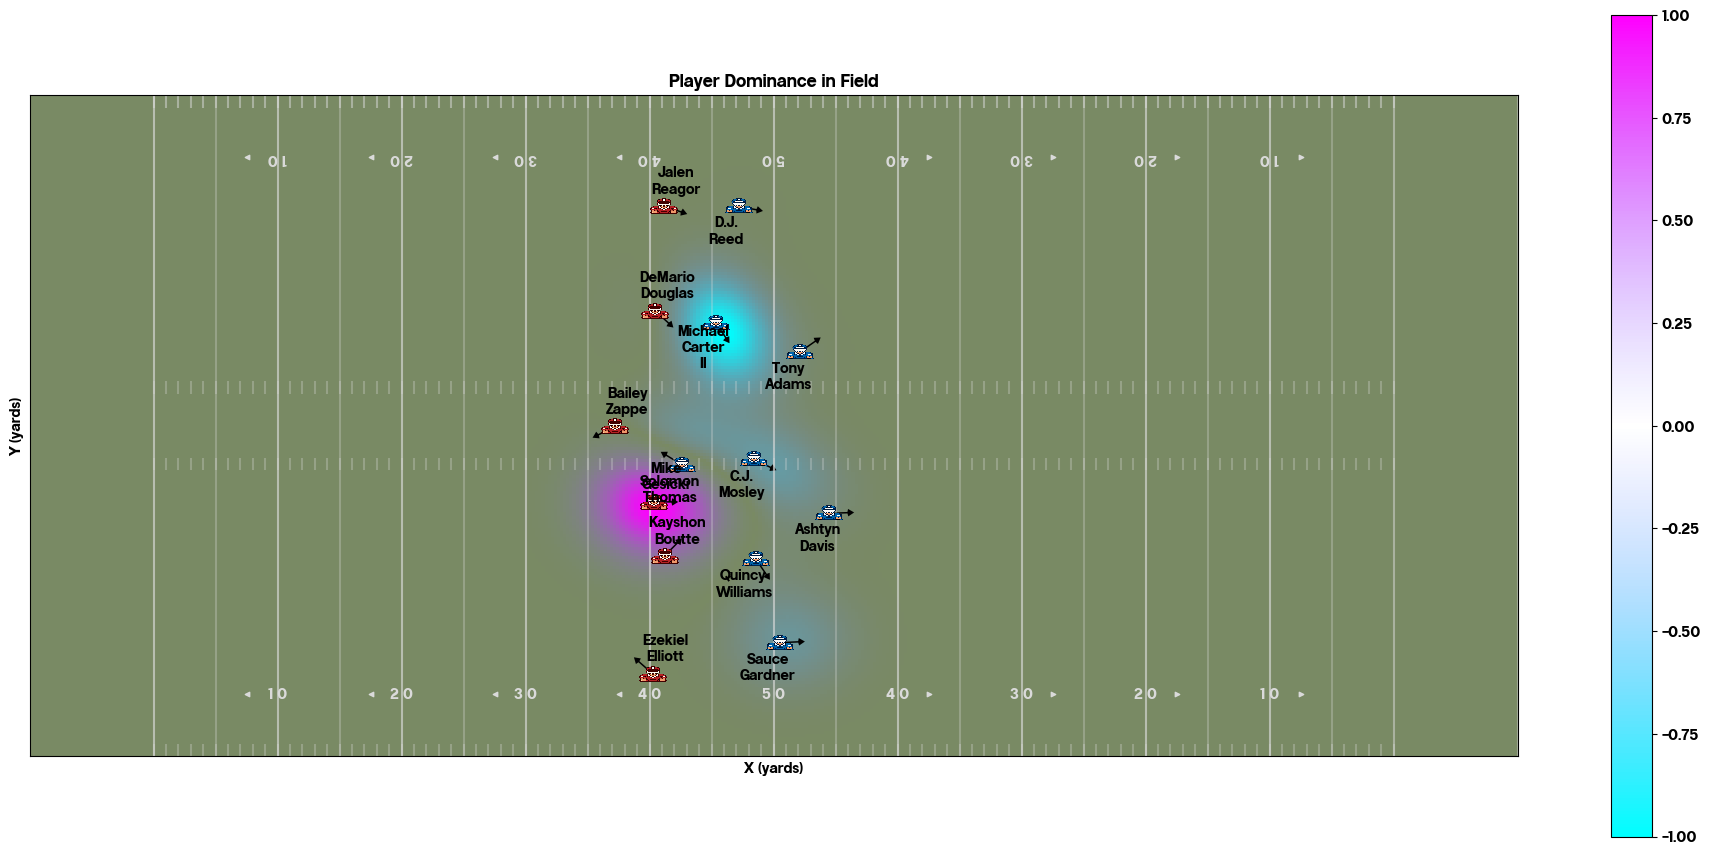

In [18]:
# Optionally compute cohesion once per frame:
test = add_team_cohesion(test, radius=12.0)

total_dominance = np.zeros_like(X, dtype=float)
for _, player in test.iterrows():
    f = dominance_function(player)   # -> callable(X, Y)
    total_dominance += f(X, Y)

total_dominance_norm = normalize_two_sided(total_dominance)

fig, ax = plot_field()
im = ax.imshow(
    total_dominance_norm,
    origin="lower",
    extent=[xs.min(), xs.max(), ys.min(), ys.max()],
    aspect="equal",
    cmap=custom_cmap
)
fig.colorbar(im, ax=ax)
scatter_png(ax, test, x='x', y='y', side='player_side', icons=icons, size=0.02)
#player_ids(ax, test, x='x', y='y', ids='player_name', id_func=None)
player_ids(ax, test, x='x', y='y', ids='player_name', id_func=lambda x: x.replace(' ', '\n'))

# Add arrows
plot_player_arrows(ax, test, dir_col='dir')

#add_dir_arrows(ax, test, x='x', y='y', dir_col='dir')

ax.set_title("Player Dominance in Field")
ax.set_xlabel("X (yards)")
ax.set_ylabel("Y (yards)")

plt.show()

In [19]:
# Dominance and stats computation:
all_dominance = []
total_all_stats_frame = []
total_frames = specific_play.frame_id.max()

#elev_angle = np.linspace(90, 90, total_frames) # inCorrect
elev_angle = np.linspace(90, 180, total_frames) # Correct
azim_angle = np.linspace(-90, -180, total_frames) # Correct
roll_angle = np.linspace(0, 0, total_frames) # Correct

counter=0

for frame_id in specific_play.frame_id.unique():
    test = specific_play[specific_play.frame_id==frame_id]
    test['player_side_numerical']= test.player_side.map({'Defense': -1, 'Offense': 1})
    total_dominance = np.zeros_like(X, dtype=float)
    for _, player in test.iterrows():
        f = dominance_function(player)  # returns a callable
        total_dominance += f(X, Y)      # works on the whole grid at once
        
    total_dominance_norm = normalize_two_sided(total_dominance)
    stats_frame = collect_frame_player_stats(
        frame_df=test,            # your per-frame player DF
        D=total_dominance_norm,   # normalized to [-1,1] piecewise
        X=X, Y=Y,
        R=5.0,                    # e.g., 6 yards radius
        sector_deg=120            # ±60° wedge for front/back
    )

    total_all_stats_frame.append(stats_frame)
    all_dominance.append(total_dominance_norm)

all_dominance_np = np.array(all_dominance)
dominance_gradient = np.gradient(all_dominance_np, axis=0)
total_all_stats_frame_df = pd.concat(total_all_stats_frame)

In [20]:
team_color = {1: 'magenta', -1: 'cyan'}

In [21]:
#hmmmm = pd.concat(total_all_stats_frame)
window = 4
q = 'share_team'
#q = 'share_team_scaled'
markers = ['s', '*', 'd', 'o', 'v', '^', 'p', 'X', 'D']
#fig, ax = plt.subplots(figsize=(30,10))
#for _nfl_id in hmmmm.nfl_id.unique():
#    s = hmmmm[hmmmm.nfl_id==_nfl_id]
#    s = s[['frame_id', q]].rolling(window=window, on='frame_id').mean()
#    s.plot(x='frame_id', y=q, ax=ax)
#    ax.text(s=_nfl_id, x=s.iloc[-1].frame_id, y=s.iloc[-1][q])
#    ax.text(s=_nfl_id, x=s.iloc[window-1].frame_id, y=s.iloc[window-1][q])
    
# Si un jugador se neutraliza terminan en el centro de la grafica
# Si queda dominante en su interacción, entonces termina arriba
# Si queda opacado en su interacción, entonces termina abajo. 

In [22]:
# for community in player_communities:
#     participants = list(community)
#     participants_all_stats_frame_df = total_all_stats_frame_df[
#         total_all_stats_frame_df.nfl_id.isin(participants)
#         ]
#     fig, ax = plt.subplots(figsize=(20,5))
#     for marker_idx, _nfl_id in enumerate(participants_all_stats_frame_df.nfl_id.unique()):
#         s = participants_all_stats_frame_df[participants_all_stats_frame_df.nfl_id==_nfl_id]
#         player_name = f"{s['player_name'].unique()[0]} ({s['player_position'].unique()[0]})"
#         s2 = s[['frame_id', q, 'team_sign']].rolling(window=window, on='frame_id').mean()
#         s2.plot(x='frame_id', y=q, ax=ax, color=s2.team_sign.map(team_color).mode()[0], label='_nolegend_')
#         s2.iloc[-1:].plot(
#             x='frame_id', y=q, ax=ax, label=player_name,
#             color=s2.team_sign.map(team_color).mode()[0], marker=markers[marker_idx], markeredgecolor='k'
#         )
#         #ax.text(s=_nfl_id, x=s.iloc[-1].frame_id, y=s.iloc[-1][q])
#         #ax.text(s=_nfl_id, x=s.iloc[window-1].frame_id, y=s.iloc[window-1][q])
#     plt.ylim(-0.1,1.1)
#     plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)


In [23]:
# all_dominance = []
# all_stats_frame = []
# counter=0
# for frame_id in specific_play.frame_id.unique():
#     test = specific_play[specific_play.frame_id==frame_id]
#     test['player_side_numerical']= test.player_side.map({'Defense': -1, 'Offense': 1})
#     total_dominance = np.zeros_like(X, dtype=float)
#     # Create to save in folder
#     folder_name = f'{game_id}_{play_id}'
#     create_folder(folder_name)
#     figure_path = f'../experiments/figures/{folder_name}/frame_{str(counter).zfill(3)}.png'
#     #if os.path.exists(figure_path):
#     #    print(figure_path)
#     #    counter += 1
#     #    continue
#     for _, player in test.iterrows():
#         f = dominance_function(player)  # returns a callable
#         total_dominance += f(X, Y)      # works on the whole grid at once
#     total_dominance_norm = normalize_two_sided(total_dominance)


#     stats_frame = collect_frame_player_stats(
#         frame_df=test,            # your per-frame player DF
#         D=total_dominance_norm,   # normalized to [-1,1] piecewise
#         X=X, Y=Y,
#         R=5.0,                    # e.g., 6 yards radius
#         sector_deg=120            # ±60° wedge for front/back
#     )

#     all_stats_frame.append(stats_frame)
#     all_stats_frame_df = pd.concat(all_stats_frame)

#     # Here starts the plotting...

#     # Defining axes
#     fig = plt.figure(figsize=(13*2,6*2))
#     #gs = gridspec.GridSpec(10, 13, wspace=0, hspace=0)
#     gs = gridspec.GridSpec(6, 13, wspace=0, hspace=0)

    
#     ax_main = plt.subplot(gs[2:5+1, 2:10+1])
#     ax_x = plt.subplot(gs[1, 2:10+1], sharex=ax_main)
#     ax_y = plt.subplot(gs[2:5+1, 1], sharey=ax_main)
#     ax_y2 = plt.subplot(gs[2:5+1, 11], sharey=ax_main)

#     #ax_c1 = plt.subplot(gs[7:8+1, 1:3+1])
#     #ax_c2 = plt.subplot(gs[7:8+1, 5:7+1])
#     #ax_c3 = plt.subplot(gs[7:8+1, 9:11+1])


#     # plot x
#     x = X[0]
#     extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
#     ax_x.imshow((total_dominance_norm.sum(axis=0)[np.newaxis,:])**1, cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
#     ax_x.set_yticks([])
#     ax_x.axis('off')
    
    
#     # plot y
#     x = Y[:,1]
#     extent = [0,1, x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.]
#     ax_y.imshow((total_dominance_norm.sum(axis=1)[:,np.newaxis][::-1]), cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
#     ax_y.set_yticks([])
#     ax_y.axis('off')

#     ax_y2.imshow((total_dominance_norm.sum(axis=1)[:,np.newaxis][::-1])**1, cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
#     ax_y2.set_yticks([])
#     ax_y2.axis('off')    
#     # Main stuff
#     ax_main = plot_field(ax_main, nfl_image=nfl_image) # Plot the field
#     ax_main.set_aspect('equal')
#     plot_ball_land(ax_main, test, icons, size=0.02) # Plot the ball
#     scatter_png(ax_main, test, x='x', y='y', side='player_side', icons=icons, size=0.02) # Plot the players
#     player_ids(ax_main, test, x='x', y='y') # Plot info from the players
#     plot_player_arrows(ax_main, test, dir_col='dir')
    
#     im = ax_main.imshow(
#         total_dominance_norm,
#         origin="lower",
#         extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#         aspect="equal",
#         cmap=custom_cmap
#     )
#     ax_total = fig.add_subplot(gs[:])
#     ax_total.axis('off')
#     #ax_total.set_title('This is a title', fontsize=30,)

#     plt.show()
#     #plt.savefig(figure_path)
#     counter += 1
#     plt.close(fig)
#     #break

In [24]:
#save_gif(folder_name)

In [25]:
#folder_name

In [26]:
# all_dominance = []
# all_stats_frame = []
# counter=0
# for frame_id in specific_play.frame_id.unique():
#     test = specific_play[specific_play.frame_id==frame_id]
#     test['player_side_numerical']= test.player_side.map({'Defense': -1, 'Offense': 1})
#     total_dominance = np.zeros_like(X, dtype=float)
#     # Create to save in folder
#     folder_name = f'{game_id}_{play_id}'
#     create_folder(folder_name)
#     figure_path = f'../experiments/figures/{folder_name}/frame_{str(counter).zfill(3)}.png'
#     #if os.path.exists(figure_path):
#     #    print(figure_path)
#     #    counter += 1
#     #    continue
#     for _, player in test.iterrows():
#         f = dominance_function(player)  # returns a callable
#         total_dominance += f(X, Y)      # works on the whole grid at once
#     total_dominance_norm = normalize_two_sided(total_dominance)


#     stats_frame = collect_frame_player_stats(
#         frame_df=test,            # your per-frame player DF
#         D=total_dominance_norm,   # normalized to [-1,1] piecewise
#         X=X, Y=Y,
#         R=5.0,                    # e.g., 6 yards radius
#         sector_deg=120            # ±60° wedge for front/back
#     )

#     all_stats_frame.append(stats_frame)
#     all_stats_frame_df = pd.concat(all_stats_frame)

#     # Here starts the plotting...

#     # Defining axes
#     fig = plt.figure(figsize=(13*2,6*2))
#     #gs = gridspec.GridSpec(10, 13, wspace=0, hspace=0)
#     gs = gridspec.GridSpec(6, 13, wspace=0, hspace=0)

    
#     ax_main = plt.subplot(gs[2:5+1, 2:10+1])
#     ax_x = plt.subplot(gs[1, 2:10+1], sharex=ax_main)
#     ax_y = plt.subplot(gs[2:5+1, 1], sharey=ax_main)
#     ax_y2 = plt.subplot(gs[2:5+1, 11], sharey=ax_main)

#     #ax_c1 = plt.subplot(gs[7:8+1, 1:3+1])
#     #ax_c2 = plt.subplot(gs[7:8+1, 5:7+1])
#     #ax_c3 = plt.subplot(gs[7:8+1, 9:11+1])


#     # plot x
#     x = X[0]
#     extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
#     ax_x.imshow((total_dominance_norm.sum(axis=0)[np.newaxis,:])**1, cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
#     ax_x.set_yticks([])
#     ax_x.axis('off')
    
    
#     # plot y
#     x = Y[:,1]
#     extent = [0,1, x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.]
#     ax_y.imshow((total_dominance_norm.sum(axis=1)[:,np.newaxis][::-1]), cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
#     ax_y.set_yticks([])
#     ax_y.axis('off')

#     ax_y2.imshow((total_dominance_norm.sum(axis=1)[:,np.newaxis][::-1])**1, cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
#     ax_y2.set_yticks([])
#     ax_y2.axis('off')    
#     # Main stuff
#     ax_main = plot_field(ax_main, nfl_image=nfl_image) # Plot the field
#     ax_main.set_aspect('equal')
#     plot_ball_land(ax_main, test, icons, size=0.02) # Plot the ball
#     scatter_png(ax_main, test, x='x', y='y', side='player_side', icons=icons, size=0.02) # Plot the players
#     player_ids(ax_main, test, x='x', y='y') # Plot info from the players
#     plot_player_arrows(ax_main, test, dir_col='dir')
    
#     im = ax_main.imshow(
#         total_dominance_norm,
#         origin="lower",
#         extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#         aspect="equal",
#         cmap=custom_cmap
#     )
#     ax_total = fig.add_subplot(gs[:])
#     ax_total.axis('off')
#     #ax_total.set_title('This is a title', fontsize=30,)

#     plt.show()
#     #plt.savefig(figure_path)
#     counter += 1
#     plt.close(fig)
#     if counter==3: break

In [27]:
def_team = specific_gameplay_supplementary_data.defensive_team.values[0]
pos_team = specific_gameplay_supplementary_data.possession_team.values[0]

def_team_img_path = f'../assets/figures/teams/{def_team}.png'
pos_team_img_path = f'../assets/figures/teams/{pos_team}.png'

# Game status:
game_status_dict = specific_gameplay_supplementary_data.iloc[0].to_dict()
gsd_vta = game_status_dict['visitor_team_abbr']
gsd_hta = game_status_dict['home_team_abbr']
gsd_psvs = game_status_dict['pre_snap_visitor_score']
gsd_pshs = game_status_dict['pre_snap_home_score']
txt_game_status = f"""Game date: {game_status_dict['game_date']} | Season: {game_status_dict['season']} | Week: {game_status_dict['week']}
{game_status_dict['quarter']}° Quarter, {game_status_dict['game_clock']} on the clock - {game_status_dict['down']}° Down, {game_status_dict['yards_to_go']} Yards to go. 
Score: ({gsd_hta}) {gsd_pshs} - {gsd_psvs} ({gsd_vta})"""

In [28]:
# fig = plt.figure(figsize=(24*2,55*2))
# gs = gridspec.GridSpec(55, 24, wspace=0, hspace=0)
# # 
# # Corners
# up_corner_l = plt.subplot(gs[0,0])
# up_corner_l.axis('off')
# up_corner_r = plt.subplot(gs[0, -1])
# up_corner_r.axis('off')

# # Margin 
# #margin = plt.subplot(gs[0:2, :])
# #img = Image.open('../assets/figures/kaggle_figure2.png')
# #img_array = np.array(img)
# #margin.imshow(img_array)
# #margin.axis('off')

# # Dominance Index
# title = plt.subplot(gs[2:3+1, 1:14+1])
# title.text(0.0, 0.5, 'Dominance index', ha='left', va='center', fontsize=180, color='k', fontweight='bold', **{'fontname':'Helotypo'})
# title.axis('off')

# # NFL logo:
# logo = plt.subplot(gs[0:4+1, 18:22+1])
# img = Image.open('../assets/figures/NFL-logo.png')
# img_array = np.array(img)
# logo.imshow(img_array)
# logo.axis('off')

# # Game status text:
# game_status_text = plt.subplot(gs[5, 2:6+1])
# game_status_text.text(0.0, 0.5, 'Game status:', ha='left', va='center', fontsize=50, color='k', fontweight='bold')
# game_status_text.axis('off')

# # Game status:
# game_status = plt.subplot(gs[5:6+1, 2:9+1])
# game_status.text(
#     0.01, 0.5, txt_game_status, fontsize=35, va='top', ha='left',   
#     bbox=dict(boxstyle='round,pad=0.5', fc='gainsboro', ec='k', lw=1)
# )
# game_status.axis('off')

# # Posesion team
# team_pos_plot = plt.subplot(gs[5:7+1, 12:14+1])

# for spine in team_pos_plot.spines.values():
#     spine.set_visible(False)

# round_box = FancyBboxPatch(
#     (-0.02, -0.02),   # a bit outside the axes
#     1.04, 1.04,       # slightly bigger than 1x1
#     boxstyle="round,pad=0.02,rounding_size=0.12",
#     transform=team_pos_plot.transAxes,
#     linewidth=3,
#     edgecolor='magenta',
#     facecolor="gainsboro",
#     clip_on=False,    # <-- important: don't clip to rectangular axes
#     zorder=0,
# )
# team_pos_plot.add_patch(round_box)
# team_pos_plot.tick_params(axis='x', length=0, labelbottom=False)
# team_pos_plot.tick_params(axis='y', length=0, labelleft=False)
# img = Image.open(pos_team_img_path)
# img_array = np.array(img)
# team_pos_plot.imshow(img_array, zorder=1)
# team_pos_plot.set_xlabel(pos_team, fontsize=30, labelpad=40)

# # Defensive team
# team_def_plot = plt.subplot(gs[5:7+1, 16:18+1])

# for spine in team_def_plot.spines.values():
#     spine.set_visible(False)
    
# round_box = FancyBboxPatch(
#     (-0.02, -0.02),   # a bit outside the axes
#     1.04, 1.04,       # slightly bigger than 1x1
#     boxstyle="round,pad=0.02,rounding_size=0.12",
#     transform=team_def_plot.transAxes,
#     linewidth=3,
#     edgecolor='cyan',
#     facecolor="gainsboro",
#     clip_on=False,    # <-- important: don't clip to rectangular axes
#     zorder=0,
# )
# team_def_plot.add_patch(round_box)

# team_def_plot.tick_params(axis='x', length=0, labelbottom=False)
# team_def_plot.tick_params(axis='y', length=0, labelleft=False)
# img = Image.open(def_team_img_path)
# img_array = np.array(img)
# team_def_plot.imshow(img_array)
# team_def_plot.set_xlabel(def_team, fontsize=30, labelpad=40)
# #team_def_plot.axis('off')

# # Vs
# vs = plt.subplot(gs[6, 15])
# vs.text(0.5, 0.5, 'VS', ha='center', va='center', fontsize=50, color='k')
# vs.axis('off')

# # Gif
# ax_main = plt.subplot(gs[11:11+8, 3:3+18])
# if True:
#     ax_main = plot_field(ax_main, nfl_image=None) # Plot the field
#     ax_main.set_aspect('equal')
#     plot_ball_land(ax_main, test, icons, size=0.02) # Plot the ball
#     scatter_png(ax_main, test, x='x', y='y', side='player_side', icons=icons, size=0.02) # Plot the players
#     player_ids(ax_main, test, x='x', y='y', ids='player_name', id_func=lambda x: x.replace(' ', '\n'))
#     plot_player_arrows(ax_main, test, dir_col='dir')
    
#     im = ax_main.imshow(
#         total_dominance_norm,
#         origin="lower",
#         extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#         aspect="equal",
#         cmap=custom_cmap
#     )

# ax_x = plt.subplot(gs[10, 3:3+18], sharex=ax_main)
# if True:
#     x = X[0]
#     extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
#     ax_x.imshow((total_dominance_norm.sum(axis=0)[np.newaxis,:])**1, cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
#     ax_x.set_yticks([])
#     ax_x.axis('off')

# ax_y = plt.subplot(gs[11:11+8, 2], sharey=ax_main)
# ax_y2 = plt.subplot(gs[11:11+8, 21], sharey=ax_main)
# if True:
#     x = Y[:,1]
#     extent = [0,1, x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.]
#     ax_y.imshow((total_dominance_norm.sum(axis=1)[:,np.newaxis][::-1]), cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
#     ax_y.set_yticks([])
#     ax_y.axis('off')
#     ax_y2.imshow((total_dominance_norm.sum(axis=1)[:,np.newaxis][::-1])**1, cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
#     ax_y2.set_yticks([])
#     ax_y2.axis('off')    


# #for i in range(24): plt.subplot(gs[11, i])

# # Gif text
# gif_text = plt.subplot(gs[20:21+1, 2:2+18+2])
# lorem_ipsum = """
# Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et 
# dolore magna aliqua.Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip 
# ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore 
# eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia 
# deserunt mollit anim id est laborum.
# """
# gif_text.text(0.01, 0.5, lorem_ipsum, fontsize=32, verticalalignment='center')
# gif_text.axis('off')


# # Interacciones
# subtitle = plt.subplot(gs[23, 2:5+1])
# subtitle.text(0.0, 0.5, 'Player Interactions:', ha='left', va='center', fontsize=100, color='k', fontweight='bold')
# subtitle.axis('off')

# # Graficas de interaccion
# community_subplot_width = 7
# community_subplot_skip_spaces = 2

# for c, community in enumerate(player_communities):
#     community_subplot_initial_pos = 25 + c * community_subplot_width
#     community_subplot_final_plot = 25 + (c + 1) * community_subplot_width-community_subplot_skip_spaces
#     community_subplot = plt.subplot(gs[community_subplot_initial_pos: community_subplot_final_plot, 2:21+# 1    participants = list(community)
#     # total_        # total_all_stats_frame_df    ]# 
#     # Plot each player individually    for _nfl_id in # total_        s = # total_        s2 = s[['frame_id', q, 'team_sign']].rolling(window=window, on='frame_id').mean()
#         s2.plot(x='frame_id', y=q, ax=community_subplot, label=_nfl_id, color=s2.team_sign.map(team_color).mode()[0], linewidth=5, alpha=0.3, linestyle='--')
#         #community_subplot.text(s=_nfl_id, x=s.iloc[-1].frame_id, y=s.iloc[-1][q])
#         #community_subplot.text(s=_nfl_id, x=s.iloc[window-1].frame_id, y=s.iloc[window-1][q])
#     community_subplot.set_ylim(-0.1,1.1)
#     community_subplot.set_ylabel('Dominance index.', fontsize=30)
#     community_subplot.set_xlabel('Time passing (by frame [1 frame is 0.1 seconds]).', fontsize=30)
#participants_all_stats_frame_df[total_participants_all_stats_frame_df.nfl_id==_nfl_id]
#participants_all_stats_frame_df.nfl_id.unique():

#.nfl_id.isin(participants)
#participants_all_stats_frame_df = total_all_stats_frame_df[

# ])
# plt.savefig('test.pdf',bbox_inches='tight', pad_inches=0)

In [29]:
def plot_report(test, total_dominance_norm, frame_id, savepath=None):
    if os.path.exists(savepath):
        print(f'File already exists at {savepath}.')
        return 
    # Main plot configuration
    fig = plt.figure(figsize=(24*2,55*2))
    gs = gridspec.GridSpec(55, 24, wspace=0, hspace=0)
    
    # Corners
    up_corner_l = plt.subplot(gs[0,0])
    up_corner_l.axis('off')
    up_corner_r = plt.subplot(gs[0, -1])
    up_corner_r.axis('off')
    
    # Margin 
    #margin = plt.subplot(gs[0:2, :])
    #img = Image.open('../assets/figures/kaggle_figure2.png')
    #img_array = np.array(img)
    #margin.imshow(img_array)
    #margin.axis('off')
    
    # Dominance Index
    title = plt.subplot(gs[2:3+1, 1:14+1])
    title.text(0.0, 0.5, 'Dominance index', ha='left', va='center', fontsize=180, color='k', fontweight='bold', **{'fontname':'Helotypo'})
    title.axis('off')
    
    # NFL logo:
    logo = plt.subplot(gs[0:4+1, 18:22+1])
    img = Image.open('../assets/figures/NFL-logo.png')
    img_array = np.array(img)
    logo.imshow(img_array)
    logo.axis('off')
    
    # Game status text:
    game_status_text = plt.subplot(gs[5, 2:6+1])
    game_status_text.text(0.0, 0.5, 'Game status:', ha='left', va='center', fontsize=50, color='k', fontweight='bold')
    game_status_text.axis('off')
    
    # Game status:
    game_status = plt.subplot(gs[5:6+1, 2:9+1])
    game_status.text(
        0.01, 0.5, txt_game_status, fontsize=35, va='top', ha='left',   
        bbox=dict(boxstyle='round,pad=0.5', fc='gainsboro', ec='k', lw=1)
    )
    game_status.axis('off')
    
    # Posesion team
    team_pos_plot = plt.subplot(gs[5:7+1, 12:14+1])
    for spine in team_pos_plot.spines.values():
        spine.set_visible(False)
    round_box = FancyBboxPatch(
        (-0.02, -0.02),   # a bit outside the axes
        1.04, 1.04,       # slightly bigger than 1x1
        boxstyle="round,pad=0.02,rounding_size=0.12",
        transform=team_pos_plot.transAxes,
        linewidth=3,
        edgecolor='magenta',
        facecolor="gainsboro",
        clip_on=False,    # <-- important: don't clip to rectangular axes
        zorder=0,
    )
    team_pos_plot.add_patch(round_box)
    team_pos_plot.tick_params(axis='x', length=0, labelbottom=False)
    team_pos_plot.tick_params(axis='y', length=0, labelleft=False)
    img = Image.open(pos_team_img_path)
    img_array = np.array(img)
    team_pos_plot.imshow(img_array, zorder=1)
    team_pos_plot.set_xlabel(pos_team, fontsize=30, labelpad=40)
    
    # Defensive team
    team_def_plot = plt.subplot(gs[5:7+1, 16:18+1])
    for spine in team_def_plot.spines.values():
        spine.set_visible(False)
    round_box = FancyBboxPatch(
        (-0.02, -0.02),   # a bit outside the axes
        1.04, 1.04,       # slightly bigger than 1x1
        boxstyle="round,pad=0.02,rounding_size=0.12",
        transform=team_def_plot.transAxes,
        linewidth=3,
        edgecolor='cyan',
        facecolor="gainsboro",
        clip_on=False,    # <-- important: don't clip to rectangular axes
        zorder=0,
    )
    team_def_plot.add_patch(round_box)
    
    team_def_plot.tick_params(axis='x', length=0, labelbottom=False)
    team_def_plot.tick_params(axis='y', length=0, labelleft=False)
    img = Image.open(def_team_img_path)
    img_array = np.array(img)
    team_def_plot.imshow(img_array)
    team_def_plot.set_xlabel(def_team, fontsize=30, labelpad=40)
    
    # Vs
    vs = plt.subplot(gs[6, 15])
    vs.text(0.5, 0.5, 'VS', ha='center', va='center', fontsize=50, color='k')
    vs.axis('off')
    
    # Gif
    ax_main = plt.subplot(gs[11:11+8, 3:3+18])
    if True:
        ax_main = plot_field(ax_main, nfl_image=None) # Plot the field
        ax_main.set_aspect('equal')
        plot_ball_land(ax_main, test, icons, size=0.02) # Plot the ball
        scatter_png(ax_main, test, x='x', y='y', side='player_side', icons=icons, size=0.02) # Plot the players
        player_ids(ax_main, test, x='x', y='y', ids='player_name', id_func=lambda x: x.replace(' ', '\n'))
        plot_player_arrows(ax_main, test, dir_col='dir')
        
        im = ax_main.imshow(
            total_dominance_norm,
            origin="lower",
            extent=[xs.min(), xs.max(), ys.min(), ys.max()],
            aspect="equal",
            cmap=custom_cmap
        )
    ax_x = plt.subplot(gs[10, 3:3+18], sharex=ax_main)
    if True:
        x = X[0]
        extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
        ax_x.imshow((total_dominance_norm.sum(axis=0)[np.newaxis,:])**1, cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
        ax_x.set_yticks([])
        ax_x.axis('off')
    ax_y = plt.subplot(gs[11:11+8, 2], sharey=ax_main)
    ax_y2 = plt.subplot(gs[11:11+8, 21], sharey=ax_main)
    if True:
        x = Y[:,1]
        extent = [0,1, x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.]
        ax_y.imshow((total_dominance_norm.sum(axis=1)[:,np.newaxis][::-1]), cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
        ax_y.set_yticks([])
        ax_y.axis('off')
        ax_y2.imshow((total_dominance_norm.sum(axis=1)[:,np.newaxis][::-1])**1, cmap=custom_cmap, aspect="auto", extent=extent,)# vmin=-1,vmax=1)
        ax_y2.set_yticks([])
        ax_y2.axis('off')    
        
    # Gif text
    gif_text = plt.subplot(gs[20:21+1, 2:2+18+2])
    lorem_ipsum = """
    Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et 
    dolore magna aliqua.Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip 
    ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore 
    eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia 
    deserunt mollit anim id est laborum.
    """
    gif_text.text(0.01, 0.5, lorem_ipsum, fontsize=32, verticalalignment='center')
    gif_text.axis('off')    

    # Interacciones
    subtitle = plt.subplot(gs[23, 2:5+1])
    subtitle.text(0.0, 0.5, 'Player Interactions:', ha='left', va='center', fontsize=100, color='k', fontweight='bold')
    subtitle.axis('off')
    
    # Graficas de interaccion
    community_subplot_width = 7
    community_subplot_skip_spaces = 2
    
    for c, community in enumerate(player_communities):
        community_subplot_initial_pos = 25 + c * community_subplot_width
        community_subplot_final_plot = 25 + (c + 1) * community_subplot_width-community_subplot_skip_spaces
        community_subplot = plt.subplot(gs[community_subplot_initial_pos: community_subplot_final_plot , 2:19])
        participants = list(community)
        total_participants_all_stats_frame_df = total_all_stats_frame_df[
            total_all_stats_frame_df.nfl_id.isin(participants)
        ]
        # Plot each player individually
        for marker_idx, _nfl_id in enumerate(total_participants_all_stats_frame_df.nfl_id.unique()):
            s = total_participants_all_stats_frame_df[total_participants_all_stats_frame_df.nfl_id==_nfl_id]
            s2 = s[['frame_id', q, 'team_sign']].rolling(window=window, on='frame_id').mean()
            s2.plot(x='frame_id', y=q, ax=community_subplot, label='_nolegend_', 
                    color=s2.team_sign.map(team_color).mode()[0], linewidth=5, alpha=0.3, linestyle='--')
            player_name = f"{s['player_name'].unique()[0]} ({s['player_position'].unique()[0]})"

            # Plot strong line (marked over time)
            s2[s2.frame_id == frame_id].plot(
                x='frame_id', y=q, ax=community_subplot, label=player_name, linewidth=6,
                color=s2.team_sign.map(team_color).mode()[0], marker=markers[marker_idx], markeredgecolor='k', markersize=15,
            )
            s2[s2.frame_id <= frame_id].plot(
                x='frame_id', y=q, ax=community_subplot, label='_nolegend_', linewidth=6,
                color=s2.team_sign.map(team_color).mode()[0], 
            )
                    
        community_subplot.set_ylim(-0.1,1.1)
        community_subplot.set_ylabel('Dominance index.', fontsize=30)
        community_subplot.set_xlabel('Time passing (by frame [1 frame is 0.1 seconds]).', fontsize=30)
        community_subplot.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, fontsize=25)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', pad_inches=0)
        print(f'Figure saved at {savepath}')
    else:
        plt.savefig(f'test_{frame_id}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

In [30]:
def get_info_for_specific_frame(frame_id):
    test = specific_play[specific_play.frame_id==frame_id]
    individual_stats = total_all_stats_frame_df[total_all_stats_frame_df.frame_id==frame_id]
    test['player_side_numerical'] = test.player_side.map({'Defense': -1, 'Offense': 1})
    test = add_team_cohesion(test, radius=12.0)
    total_dominance = np.zeros_like(X, dtype=float)
    for _, player in test.iterrows():
        f = dominance_function(player)  # returns a callable
        total_dominance += f(X, Y)      # works on the whole grid at once
    total_dominance_norm = normalize_two_sided(total_dominance)
    return test, total_dominance_norm, frame_id, individual_stats

def save_info_for_ml_model(test, individual_stats, filepath):
    if os.path.exists(filepath):
        print(f'File already exists at {filepath}.')
        return None
    merged_test_stats = test.merge(
        individual_stats[['nfl_id', 'share_team']],
        on='nfl_id',
        how='left'
    )
    helper_ids = ['game_id', 'play_id','nfl_id', 'frame_id']
    helper_context = ['play_direction', 'absolute_yardline_number']
    helper_features = [
        'player_height', 'player_weight', 'player_position',
        'x', 'y','s', 'a', 'dir', 'o',
        'player_side_numerical', 'team_cohesion'
    ]
    helper_predictor = ['share_team']
    helper_variables = helper_ids + helper_context + helper_features + helper_predictor
    data = merged_test_stats[helper_variables]
    data.to_parquet(filepath)
    print(f'File saved at {filepath}.')
    return 

In [31]:
# frame_id = 10
# test, total_dominance_norm, frame_id, individual_stats = get_info_for_specific_frame(frame_id)
# plot_report(test, total_dominance_norm, frame_id, savepath='./test.png')

In [32]:
for frame_id in specific_play.frame_id.unique():
    folder_name = f'report__{game_id}_{play_id}'
    create_folder(folder_name)
    figure_path = f'../experiments/figures/{folder_name}/frame_{str(frame_id).zfill(3)}.png'
    data_path = f'../data/interim/{folder_name}_{str(frame_id).zfill(3)}.parquet'
    test, total_dominance_norm, frame_id, individual_stats = get_info_for_specific_frame(frame_id)
    plot_report(test, total_dominance_norm, frame_id, savepath=figure_path)
    save_info_for_ml_model(test, individual_stats, data_path)

Figure saved at ../experiments/figures/report__2024010704_3632/frame_001.png
File saved at ../data/interim/report__2024010704_3632_001.parquet.
Figure saved at ../experiments/figures/report__2024010704_3632/frame_002.png
File saved at ../data/interim/report__2024010704_3632_002.parquet.
Figure saved at ../experiments/figures/report__2024010704_3632/frame_003.png
File saved at ../data/interim/report__2024010704_3632_003.parquet.
Figure saved at ../experiments/figures/report__2024010704_3632/frame_004.png
File saved at ../data/interim/report__2024010704_3632_004.parquet.
Figure saved at ../experiments/figures/report__2024010704_3632/frame_005.png
File saved at ../data/interim/report__2024010704_3632_005.parquet.
Figure saved at ../experiments/figures/report__2024010704_3632/frame_006.png
File saved at ../data/interim/report__2024010704_3632_006.parquet.
Figure saved at ../experiments/figures/report__2024010704_3632/frame_007.png
File saved at ../data/interim/report__2024010704_3632_007.p

In [ ]:
#print(folder_name)
#save_gif(folder_name)